In [ ]:
%pip install pandas matplotlib numpy seaborn scipy
%pip install scikit-learn
%pip install scikeras

In [ ]:
# Importing essential libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pylab
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime as dt
from scipy.spatial.distance import cdist
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import median
from os.path import isfile
from sklearn.linear_model import LinearRegression
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [ ]:
###############################################################################
# Loading dataset
if isfile('Online%20Retail.xlsx'):
    print("Loading dataset")
    retail_data = pd.read_excel('Online%20Retail.xlsx')
else:
    print("Downloading dataset")
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
    retail_data = pd.read_excel(url)

retail_data.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Custom

In [ ]:
###############################################################################
# preparing dataset

# RFM rating 1..5: from 111 to 555 (worst=111 to best=555)
levels = 5

#Delete rows with missing CustomerID
retail_data = retail_data.drop(retail_data[retail_data.CustomerID.isnull()].index).reset_index(drop=True) #Changing the datatype of Customer Id into int
retail_data['CustomerID'] = pd.to_numeric(retail_data['CustomerID'], downcast = 'integer') #Delete orders where Unit Price is 0
retail_data = retail_data.drop(retail_data[retail_data.UnitPrice==0].index).reset_index(drop=True) #Create a new column for total price
retail_data['TotalPrice'] = retail_data.Quantity*retail_data.UnitPrice
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

In [ ]:
###############################################################################
# RFM
cutOffDate = retail_data['InvoiceDate'].max()   # or dt.datetime(y,m,d)
rfm = retail_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (cutOffDate - x.max()).days,
                                             'InvoiceNo': 'count',
                                             'TotalPrice': 'sum'}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

###############################################################################
# RFM rankings. Assuming levels=5
# good customers are 555
# bad customers are 111
# potentially 5x5x5=125 combinations
rfm['r_percentile'] = rfm['Recency'].rank(pct=True,ascending=False) # the more recent the better
rfm['r_score'] = pd.qcut(rfm['r_percentile'], levels, labels=range(1, levels+1))

rfm['f_percentile'] = rfm['Frequency'].rank(pct=True,ascending=True) # the more purchases the better
rfm['f_score'] = pd.qcut(rfm['f_percentile'], levels, labels=range(1, levels+1))

rfm['m_percentile'] = rfm['MonetaryValue'].rank(pct=True,ascending=True) # the more spent the better
rfm['m_score'] = pd.qcut(rfm['m_percentile'], levels, labels=range(1, levels+1))

#rfm_scores = rfm[['CustomerID', 'r_score', 'f_score', 'm_score']]
rfm['score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
print('We have', len(rfm.score.unique()), 'different RFM rankings (from a max of', levels*levels*levels,')')

# weighted RFM score (typical weights)
rfm.r_score = pd.to_numeric(rfm.r_score)
rfm.f_score = pd.to_numeric(rfm.f_score)
rfm.m_score = pd.to_numeric(rfm.m_score)
rfm['rfm_score'] = 0.15*rfm.r_score + 0.28*rfm.f_score + 0.57*rfm.m_score

We have 121 different RFM rankings (from a max of 125 )


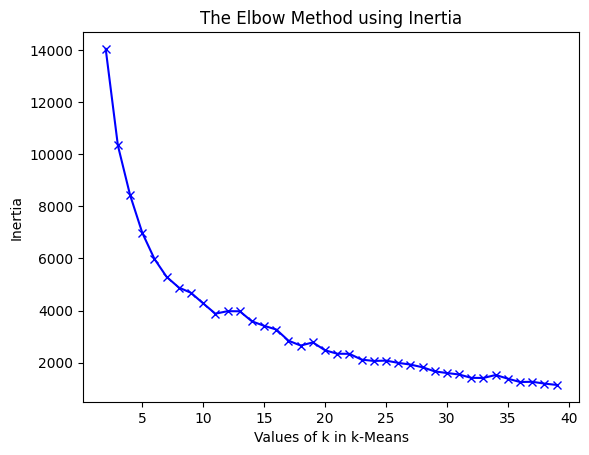

In [ ]:
###############################################################################
# RFM often produces over segmentation (here 121 combinations). It's too many!
# Can we reduce it to a more manageable number?
# Let's see what kNN finds. Target a "small" number of clusters

inertias = []
mapping = {}
X = rfm[['r_score', 'f_score', 'm_score', 'rfm_score']]     # dataset for clustering
K = range(2, 40)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto', init='k-means++').fit(X)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of k in k-Means')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
# from around k=12 is where the plot looks linear
k = 12
X = rfm[['r_score', 'f_score', 'm_score', 'rfm_score']]     # make sure we use the same dataset

###############################################################################
# Let's evaluate our selection of 'levels' and 'cluster' assignments in the
# prediction of MonetaryValue.
kmeanModel = KMeans(n_clusters=k, n_init='auto', init='k-means++').fit(X)
X['cluster'] = kmeanModel.labels_+1

y = rfm.MonetaryValue
cv = KFold(10)              # write in your thesis what 10-fold CV is about

# the regression is as follows:
print("X =", X.head())
print("y =", y.head())

X =    r_score  f_score  m_score  rfm_score  cluster
0        1        1        1       1.00        6
1        5        5        5       5.00        8
2        2        3        4       3.42       11
3        4        4        4       4.00        5
4        1        2        2       1.85        4
y = 0       0.00
1    4310.00
2    1797.24
3    1757.55
4     334.40
Name: MonetaryValue, dtype: float64


<ipython-input-9-4c7998f09e70>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeanModel.labels_+1


In [ ]:
##### Here we use R, F, and opt_clusters for the prediction of monetary value!

# TODO: Create a table for each of the following three loss functions:
#loss = 'neg_mean_absolute_error'
#loss = 'neg_mean_squared_error'
loss = 'neg_median_absolute_error'
###loss = 'r2'        ## yes, it exist, but the problem is non-linear, do not use it!

# Evaluate cluster assignment for the prediction of MonetaryValue using linear regression
scores = cross_val_score(LinearRegression(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('Linear regression:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# Linear regression: neg_median_absolute_error of -1848.0261326273076 for k= 12 and levels= 5

# Evaluate cluster assignment for the prediction of MonetaryValue using GBM
scores = cross_val_score(GradientBoostingRegressor(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('GBM:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# GBM: neg_median_absolute_error of -1152.617297800452 for k= 12 and levels= 5

# Evaluate cluster assignment for the prediction of MonetaryValue using RF
scores = cross_val_score(RandomForestRegressor(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('RF:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# RF: neg_median_absolute_error of -1146.209496149393 for k= 12 and levels= 5

# Evaluate cluster assignment for the prediction of MonetaryValue using AdaBoost
scores = cross_val_score(AdaBoostRegressor(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('AdaBoost:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# AdaBoost: neg_median_absolute_error of -1175.0010133702722 for k= 12 and levels= 5

# Evaluate cluster assignment for the prediction of MonetaryValue using ET
scores = cross_val_score(ExtraTreesRegressor(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('ET:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# ET: neg_median_absolute_error of -1161.1773418021419 for k= 12 and levels= 5

# Evaluate cluster assignment for the prediction of MonetaryValue using HistGBM
scores = cross_val_score(HistGradientBoostingRegressor(), X, y, scoring=loss, cv=cv, n_jobs=-1)
print('HistGBM:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# HistGBM: neg_median_absolute_error of -1143.205506848357 for k= 12 and levels= 5

Linear regression: neg_median_absolute_error of -1312.2485574756925 for k= 12 and levels= 5
GBM: neg_median_absolute_error of -98.1816030868504 for k= 12 and levels= 5
RF: neg_median_absolute_error of -95.96193378569068 for k= 12 and levels= 5
AdaBoost: neg_median_absolute_error of -230.34802524631726 for k= 12 and levels= 5
ET: neg_median_absolute_error of -95.26689064856708 for k= 12 and levels= 5
HistGBM: neg_median_absolute_error of -95.78768151981473 for k= 12 and levels= 5


In [ ]:
# last, but not least, one regression using a neural network.
# here is a simple neural network: input layer, hidden layer, output layer.
# feel free to make it wider and/or deeper (if you want to)
def baseline_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))       # r_score, f_score, m_score, rfm_score, cluster
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = []
estimator.append(('standardize', StandardScaler()))         # write it down as part of your data preparation section
estimator.append(('mlp', KerasRegressor(model=baseline_model, epochs=50, verbose=0)))
pipeline = Pipeline(estimator)

# Evaluate cluster assignment for the prediction of MonetaryValue using HistGBM
scores = cross_val_score(pipeline, X, y, scoring=loss, cv=cv, n_jobs=-1)
print('NN:', loss, 'of', median(scores), 'for k=', k, 'and levels=', levels)
# Sample output:
# NN: neg_median_absolute_error of -1345.593287856444 for k= 12 and levels= 5


NN: neg_median_absolute_error of -253.07057922363282 for k= 12 and levels= 5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17409 (68.00 KB)
Trainable params: 17409 (68.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


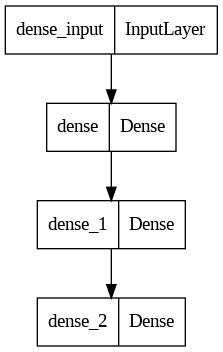

In [ ]:
# you can see the internal architecture of your neural network as follows.
# write down the final architecture you use & include the plot
model = baseline_model()
model.summary()
plot_model(model)

In [ ]:
# Change the 'loss' function and write a tables showing the best outcome. For discussions write something about neg_median_absolute_error,
# and that the best prediction comes from HistGBM, while the worst is (of course!) the linear regression. Similar discussions for each
# loss function